# This Notebook is created to hiligh the usage of methods and evaluation metric used in "Engineering and evaluating an unsupervised predictive maintenance solution: a real world case-study"

These methods are to simulate the procedure of online streaming (i.e take as input a pandas dataframe).

## Table of Contents
* [1 Load data](#lookdata)
* [2 Profile Based (and variants)](#pb)
    * [PB using external profile](#pbexternal)
    * [PB with reseting profile](#pbresets)
    * [PB with features](#Pbfeats)
* [3 PdM_TranAD](#tranad)
* [4 Run-to-failure Evaluation](#evaluation)
    * [Parameters](#parameterdescription)
    * [Evaluating PB](#pbevaluation)
    * [Evaluating PdM_TranAD](#tranad)
* [Using Prophet](#fbprophet)

In [1]:
import methods
import pandas as pd
from matplotlib import pyplot as plt


numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
Using backend: pytorch


#### Some useful functions to plot data


In [2]:
def plotrow(row,color):
    plt.plot(row,color=color)
def plotmanyrows(rows,color):
    for row in rows:
        plotrow(row,color)


## Dive into the force signal of the press and take a look of their shape <a class="anchor" id="lookdata"></a>

### Load a run-to-failure episode


In [4]:
df=pd.read_csv("CaseStudyData/Episode2.csv",index_col=0)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1024,0.08,0.08,0.07,0.08,0.07,0.07,0.08,0.07,0.07,0.07,...,2.42,2.42,2.42,2.42,2.42,2.42,2.42,2.42,2.41,2.40
1025,0.10,0.10,0.10,0.09,0.10,0.09,0.10,0.09,0.08,0.08,...,2.55,2.55,2.54,2.53,2.54,2.53,2.52,2.52,2.51,2.51
1026,0.07,0.07,0.06,0.06,0.06,0.05,0.05,0.05,0.05,0.05,...,2.54,2.53,2.53,2.52,2.52,2.52,2.51,2.50,2.49,2.49


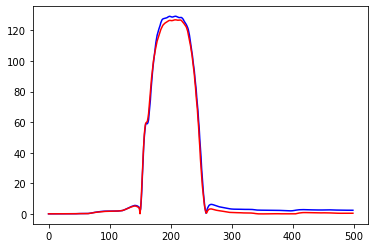

In [5]:

plotrow(df.values[0],color="blue")
plotrow(df.values[-1],color="red")
plt.show()

### We performe horizontal normalization to get all punch signal between [0,1]

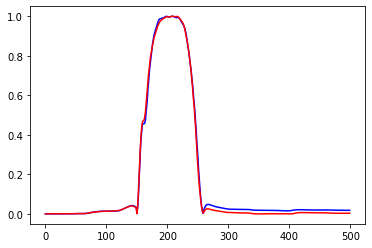

In [6]:
df = df.sub(df.min(axis=1), axis=0).div(df.max(axis=1) - df.min(axis=1), axis=0)

plotrow(df.values[0],color="blue")
plotrow(df.values[-1],color="red")
plt.show()

# Profile Based algorithm <a class="anchor" id="pb"></a>
We can apply the profile based algorithm.

### The main parameters are:
**df**: here a dataframe is expected with data

**metric**: the distance metric to use (SBT, Euclidean, DTW, Rbf kernel, with default = "euclidean").

**profileSize**: the size of profile to calculate (default:60)

**thresholdTec**: Indicate the threshold calculation technique. There are two possible choices "SelfTuning" or "MaxInnerDistance (default**: SelfTuning). More informations about the threshold calculation can be found in the paper.

**factor**: the multiplier factor to use in the threshold calculation. 

**LimitMaxdist**: It is the threshold to use in order to accept a potential profile, when None is passed the automatic profile calculation is used (deafault=None)

**window_ma**: In case we want to produce smoother anomaly score the last window_ma values are used to calculate a median as the anomaly score of the current (each time) point. (default=0)


**return**:The algorithm return the results of the method: a sequence of anomaly scores and the calculated threshold

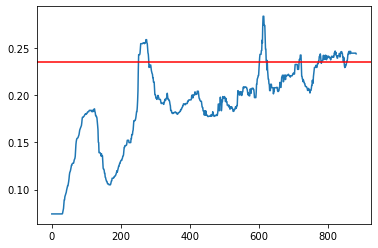

In [7]:
# apply profilebase algorithm
# We choose Selftuning technique to calculate threshold and window_ma=30 for smoothing the anomaly scores.
# Moreover by defaulr (LimitMaxdist = None) we choose the automatic proccess of profile calculation.
# the execution time is depending on choice of distance metric
anomalyscores,threshold=methods.profileBased(df,metric="euclidean",profileSize=60,factor=7,window_ma=30)

plt.plot(anomalyscores)
plt.axhline(threshold,color="red")
plt.show()



Trying a different distance metric (using SBD distance)

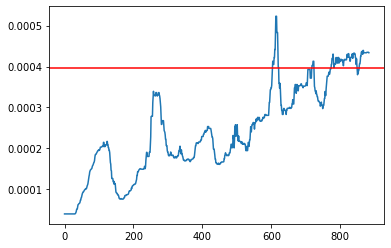

In [8]:

anomalyscores,threshold=methods.profileBased(df,metric="cc",profileSize=60,factor=14,window_ma=30)

plt.plot(anomalyscores)
plt.axhline(threshold,color="red")
plt.show()

Testing a different thresholding technique

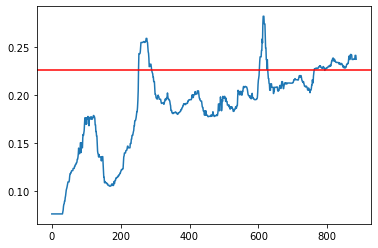

In [9]:

anomalyscores,threshold=methods.profileBased(df,metric="euclidean",profileSize=60,factor=0.4,window_ma=30,thresholdTec="MaxInnerDistance")

plt.plot(anomalyscores)
plt.axhline(threshold,color="red")
plt.show()

### Using an external profile to calculate the error <a class="anchor" id="pbexternal"></a>

We first load the data

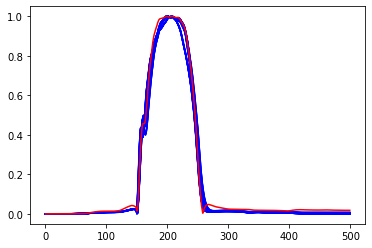

In [30]:
profile_df=pd.read_csv("datasamples/ExternalProfil.csv",index_col=0)
# as previously performing a nomralization for each row
profile_df = profile_df.sub(profile_df.min(axis=1), axis=0).div(profile_df.max(axis=1) - profile_df.min(axis=1), axis=0)

# we plot the first row of the episode data and the Reference profile data
plotmanyrows(profile_df.values,"blue")
plt.plot(df.values[0],color="red")
plt.show()


#### Now we can use the profileBasedRef() to pass the external profile

Parameters are the same as profile based, except an extra parameter:

**profile_df** which is the external profile.

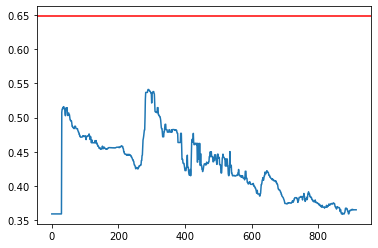

In [31]:
# run profile based with external profile.
anomalyscores,threshold=methods.profileBasedRef(df,profile_df,metric="euclidean",profileSize=60,factor=2,window_ma=30)
plt.plot(anomalyscores)
plt.axhline(threshold,color="red")
plt.show()

### What if we want to reset the profile in an event of interest. <a class="anchor" id="pbresets"></a>

In that case we can use the **profileBasedWithResets** method.
The only additional parameter is a list (**Resets**) with the indexes we want to calculate a new profile .


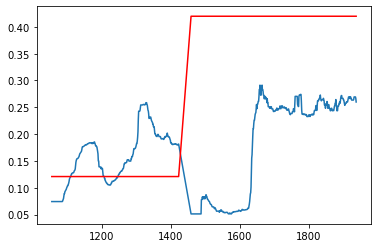

In [12]:
# suposed that an event of interest took place a time 400, 
# where we wanted the algorithm to reset and recalculate the profile.
# In that case we can use the profileBasedWithResets to simulate it.
Resets=[400]


allerrors,allindexes,allthresholds=methods.profileBasedWithResets(df,Resets,metric="euclidean",profileSize=60,factor=2,window_ma=30,thresholdTec="SelfTuning",LimitMaxdist = None)

plt.plot(allindexes,allerrors)
plt.plot(allindexes,allthresholds,color="red")
plt.show()

## Transforming rows to features  <a class="anchor" id="Pbfeats"></a>

We can calculate features for each row of data and then performe ProfileBased.

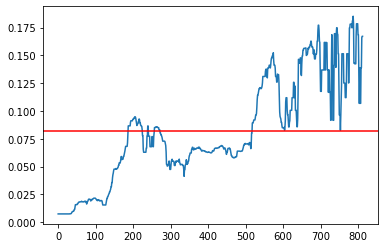

In [13]:
# minmaxnormilization indicates whether we want to perform MinMax normilazation to data. 
# if historicDf is given then the features are calculated also to these data and min and 
#      max are calculated to be used for the normilization.
# (default) if if historicDf is None then the min max normalization is performed using min max of episode data.
df=pd.read_csv("CaseStudyData/Episode2.csv",index_col=0)

dfFeats=methods.calculateFeatures(df,historicDf=None,minmaxnormilization=True)

anomalyscores,threshold=methods.profileBased(dfFeats,metric="euclidean",profileSize=60,factor=6.5,window_ma=30)

plt.plot(anomalyscores)
plt.axhline(threshold,color="red")
plt.show()

# PDM TranAD model <a class="anchor" id="tranad"></a>

Lets try to use a Dnn solution

In [14]:
import methods
import pandas as pd
from matplotlib import pyplot as plt

### Parameters

Parameters are the same as profile based technique with the difference that there is **only** the choise of **Selftunning** to calculate threshold.

some aditional parameters regarding TranAD model are:

**epochs** : the number of epochs to train the TranAD model in the calculated profile (default 10).

**profileporpotion** : used to indicate the porpotion of profile that is used for training and threshold calculation. Should belong to (0,1). Default is 0.6 (60% of profile for training and 40% for threshold calculation).

25
Creating new model: TranAD
Devise for data: False


  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/agiannous/Desktop/gitProjects/TestForPaper/TranADscripts.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_x = torch.tensor(data.clone().detach().requires_grad_(True));
 20%|████████▊                                   | 2/10 [00:00<00:00,  8.08it/s]

Epoch 0,	L1 = 0.417023850742106
Epoch 1,	L1 = 0.3771094743693295
Epoch 2,	L1 = 0.2923026715921745


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00, 10.54it/s]

Epoch 3,	L1 = 0.23645534175290986
Epoch 4,	L1 = 0.18716161598364087
Epoch 5,	L1 = 0.1439683207582735


 80%|███████████████████████████████████▏        | 8/10 [00:00<00:00,  9.62it/s]

Epoch 6,	L1 = 0.10874375424051386
Epoch 7,	L1 = 0.07803151289348913
Epoch 8,	L1 = 0.05414507339970526


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.67it/s]


Epoch 9,	L1 = 0.03790550983512882


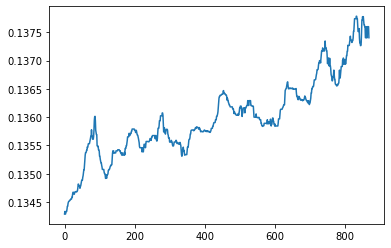

In [15]:
df=pd.read_csv("CaseStudyData/Episode1.csv",index_col=0)
df = df.sub(df.min(axis=1), axis=0).div(df.max(axis=1) - df.min(axis=1), axis=0)

anomalyscores,threshold=methods.PdM_Tranad(df,profileSize=100,factor=2,window_ma=30,epochs=10)

plt.plot(anomalyscores)
plt.plot(threshold,color="red")
plt.show()

# Evaluate multiple Run-to-Failure episodes <a class="anchor" id="evaluation"></a>

In [16]:
import evaluation
import methods
import pandas as pd
from matplotlib import pyplot as plt


#### Load data and run profile Based for each episode and store results:

In [17]:
df2=pd.read_csv("CaseStudyData/Episode1.csv",index_col=0)
df2 = df2.sub(df2.min(axis=1), axis=0).div(df2.max(axis=1) - df2.min(axis=1), axis=0)

df=pd.read_csv("CaseStudyData/Episode2.csv",index_col=0)
df = df.sub(df.min(axis=1), axis=0).div(df.max(axis=1) - df.min(axis=1), axis=0)


predictions=[]
thresholds=[]
for episodedf in [df,df2]:
    anomalyscores,threshold=methods.profileBased(episodedf,metric="cc",profileSize=60,factor=10,window_ma=30)
    predictions.append(anomalyscores)
    thresholds.append(threshold)

## This method is used to perform PdM evaluation of Run-to-Failures examples. <a class="anchor" id="parameterdescription"></a>

Running this method we can get the fbeta score given a predictive horizon and lead time for all AD1,AD2 and AD3 levels as described in the paper.

### Parameters:

**predictions**:  Either a flatted list of all predictions from all episodes or list with a list of predictions for each of of episodes. (Must given)

**datesofscores**: Either a flatted list of all indexes/timestamps from all episodes or list with a list of indexes (timestamps) for each of episodes. If it is empty list then aritificially indexes are generated (defaulr: empty). In case of timestamps pd.datetime type should be used.

**threshold**: can be either a list of thresholds (equal size to all predictions), a list with size equal to number of episodes or a single number. By this way we can test thresholding techniques that refine the threshold in the same episode, a different constant threshold for each different episode or a constant one for all episodes. (Must given)

**maintances**: is used only in case the predictions are passed as flatten array. It should be a list of ints which indicate the time of maintenance (the position in predictions where a new episode begins) or the end of the episode. (Default is None).

**isfailure**: a binary array which is used in case we want to pass episode which ends with no failure, and thus don't contribute to recall calculation. For example isfailure=[1,1,0,1] indicates that the third episode end with no failure, while the others end with a failure. Default value is empty list which indicate that all episodes end with failure.

**PH**: is the predictive horizon used for recall, can be set in time domain using one from accepted time spans: ["days", "seconds", "microseconds", "milliseconds", "minutes", "hours", "weeks"] after a space from a number e.g. PH="8 hours". In case of single number then a counter related predictive horizon is used (e.g. PH="100" indicates that the last 100 values are as predictive horizon. (Must given)

**lead**: represent the lead time (the time to ignore in last part of each episode when we want to test the predictive capabilities of algorithm), same rules as the PH are applied. (Must given)

**ignoredates**: a list with tuples (e.g. [(begin,end),(begin,end), ...] which indicate periods to be ignored in the calculation of recall and precision, begin and end values must be same type with datesofscores instances (pd.datetime or int) if given.

**beta**: the beta value for the f beta score calculation (default 1 for F1 score).

**plotThem**: boolean parameter if True then calculates the axes to plot the episodes (default True).


**return**: the method return the three levels of AD1,AD2 and AD3 for F-beta score and recall, and precision value. Moreover returns the axes in case we want to add informations such as title and others. 

## Profile based evaluation <a class="anchor" id="pbevaluation"></a>

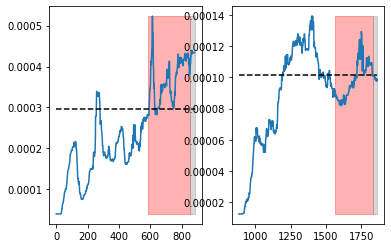

F1: AD1 0.7069306930693069,AD2 0.5984911986588433,AD3 0.5419035427493688
Recall: AD1 1.0,AD2 0.6611111111111112,AD3 0.5371832718327184
Precission: 0.5467075038284839


In [18]:
recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholds,PH="300",lead="30")
plt.show()

print(f"F1: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")

### Setting a constant threshold don't work well.

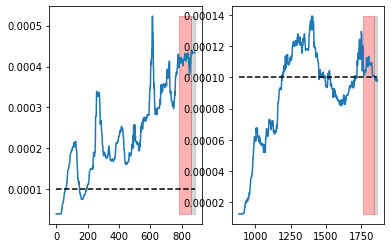

F1: AD1 0.2368615840118431,AD2 0.2368615840118431,AD3 0.2368615840118431
Recall: AD1 1.0,AD2 1.0,AD3 1.0
Precission: 0.1343408900083963


In [19]:
recall,Precision,fbeta,axes=evaluation.myeval(predictions,0.0001,PH="100",lead="20")
plt.show()
print(f"F1: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")

### We can calculate also fbeta (for example beta=2 for f2 score)

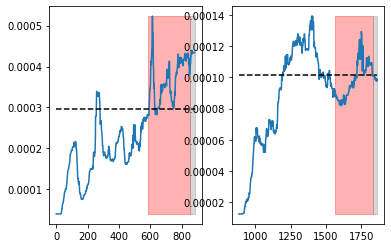

F2: AD1 0.857760691975012,AD2 0.6345538570920726,AD3 0.5390614778346202
Recall: AD1 1.0,AD2 0.6611111111111112,AD3 0.5371832718327184
Precission: 0.5467075038284839


In [20]:
recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholds,PH="300",lead="30",beta=2)
plt.show()

print(f"F2: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")

#### In case we want to set ignore periods (for example due to known errors unrelated to the monitored module we can use ingore parameter

For example let's supose we want to ingore the period 1200 until 1400.

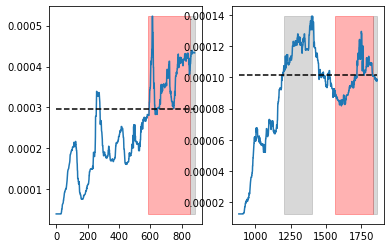

F2: AD1 0.9484590860786398,AD2 0.6828615149196634,AD3 0.5735288710211186
Recall: AD1 1.0,AD2 0.6611111111111112,AD3 0.5371832718327184
Precission: 0.7863436123348018


In [21]:
ingoreperiods=[(1200,1400)]

recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholds,PH="300",lead="30",beta=2,ignoredates=ingoreperiods)
plt.show()

print(f"F2: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")

## Evaluate Pdm_TranAD <a class="anchor" id="evaluateTranad"></a>

In [22]:
import evaluation
import methods
import pandas as pd
from matplotlib import pyplot as plt

In [25]:
df2=pd.read_csv("CaseStudyData/Episode1.csv",index_col=0)
df2 = df2.sub(df2.min(axis=1), axis=0).div(df2.max(axis=1) - df2.min(axis=1), axis=0)

df=pd.read_csv("CaseStudyData/Episode2.csv",index_col=0)
df = df.sub(df.min(axis=1), axis=0).div(df.max(axis=1) - df.min(axis=1), axis=0)

df3=pd.read_csv("CaseStudyData/Episode8.csv",index_col=0)
df3 = df3.sub(df3.min(axis=1), axis=0).div(df3.max(axis=1) - df3.min(axis=1), axis=0)

df4=pd.read_csv("CaseStudyData/Episode9.csv",index_col=0)
df4 = df4.sub(df4.min(axis=1), axis=0).div(df4.max(axis=1) - df4.min(axis=1), axis=0)


In [26]:
predictions=[]
thresholds=[]
for episodedf in [df,df2,df3,df4]:
    anomalyscores,threshold=methods.PdM_Tranad(episodedf,profileSize=60,factor=3,window_ma=30,epochs=10)
    predictions.append(anomalyscores)
    thresholds.append(threshold)



1
Creating new model: TranAD
Devise for data: False


  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/agiannous/Desktop/gitProjects/TestForPaper/TranADscripts.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_x = torch.tensor(data.clone().detach().requires_grad_(True));
 20%|████████▊                                   | 2/10 [00:00<00:00, 15.68it/s]

Epoch 0,	L1 = 0.4552945067264839
Epoch 1,	L1 = 0.3788507299274191


 40%|█████████████████▌                          | 4/10 [00:00<00:00, 16.34it/s]

Epoch 2,	L1 = 0.32777076536376276
Epoch 3,	L1 = 0.2734804431388845


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00, 15.92it/s]

Epoch 4,	L1 = 0.21648687393737712
Epoch 5,	L1 = 0.1629216532958699


Epoch 6,	L1 = 0.12115380074780503


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.72it/s]


Epoch 7,	L1 = 0.08402898153213513
Epoch 8,	L1 = 0.05809142551028194
Epoch 9,	L1 = 0.0376246289582437
15
Creating new model: TranAD
Devise for data: False


Epoch 0,	L1 = 0.42641123921796104
Epoch 1,	L1 = 0.3511740395151215


 40%|█████████████████▌                          | 4/10 [00:00<00:00, 15.43it/s]

Epoch 2,	L1 = 0.2715531326980692
Epoch 3,	L1 = 0.21171914270717743


 40%|█████████████████▌                          | 4/10 [00:00<00:00, 15.43it/s]

Epoch 4,	L1 = 0.16162183648232242


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00, 15.02it/s]

Epoch 5,	L1 = 0.12026704097832594
Epoch 6,	L1 = 0.09017180135919367
Epoch 7,	L1 = 0.06581676747659289


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.10it/s]


Epoch 8,	L1 = 0.04725237392781656
Epoch 9,	L1 = 0.033701210793811325
5
Creating new model: TranAD
Devise for data: False


 20%|████████▊                                   | 2/10 [00:00<00:00, 16.41it/s]

Epoch 0,	L1 = 0.2716811068607109
Epoch 1,	L1 = 0.2917222204924512


 40%|█████████████████▌                          | 4/10 [00:00<00:00,  8.34it/s]

Epoch 2,	L1 = 0.20098770028363241
Epoch 3,	L1 = 0.15510568777253453


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00,  7.86it/s]

Epoch 4,	L1 = 0.12781346156478168
Epoch 5,	L1 = 0.10194785565419265
Epoch 6,	L1 = 0.08145582930535976


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.22it/s]


Epoch 7,	L1 = 0.06356321786554796
Epoch 8,	L1 = 0.04967111738915426
Epoch 9,	L1 = 0.037742453604265674
24
Creating new model: TranAD
Devise for data: False


 20%|████████▊                                   | 2/10 [00:00<00:00, 15.99it/s]

Epoch 0,	L1 = 0.4085194093209184
Epoch 1,	L1 = 0.3367796282543917
Epoch 2,	L1 = 0.2759225442938393


 40%|█████████████████▌                          | 4/10 [00:00<00:00, 16.62it/s]

Epoch 3,	L1 = 0.21928123861957569


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00, 16.12it/s]

Epoch 4,	L1 = 0.1731543367373738
Epoch 5,	L1 = 0.1305678640345554
Epoch 6,	L1 = 0.09888105314707982


 80%|███████████████████████████████████▏        | 8/10 [00:00<00:00, 16.23it/s]

Epoch 7,	L1 = 0.07163510186994214


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 16.58it/s]


Epoch 8,	L1 = 0.05051731010982759
Epoch 9,	L1 = 0.034897937200971535


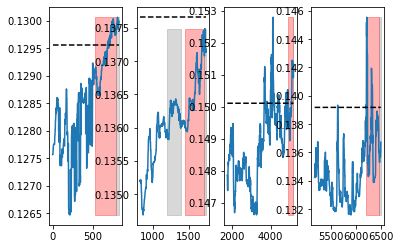

F2: AD1 0.5231788079470199,AD2 0.2838323353293413,AD3 0.11171109296271084
Recall: AD1 0.75,AD2 0.21944444444444444,AD3 0.06487661913656173
Precission: 0.4016949152542373


In [27]:
recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholds,PH="300",lead="30",beta=1,ignoredates=ingoreperiods)
plt.show()
print(f"F2: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")

## Fb prophet forecasting <a class="anchor" id="fbprophet"></a>

In [1]:
import methods
import pandas as pd
from matplotlib import pyplot as plt


numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
Using backend: pytorch
Importing plotly failed. Interactive plots will not work.


Suppress of stdout and stderr from fbprophet implementation

In [2]:
import os
import sys
from fbprophet import Prophet


# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

# Using Prophet 

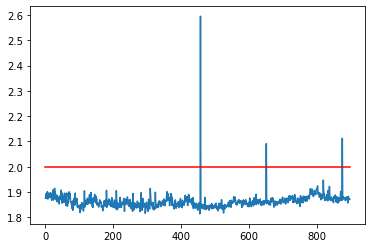

In [18]:
df=pd.read_csv(f"CaseStudyData/Episode1.csv",index_col=0)
isfailure.append(1)

df = df.sub(df.min(axis=1), axis=0).div(df.max(axis=1) - df.min(axis=1), axis=0)
with suppress_stdout_stderr():
    anomalyscores,threshold=methods.fbprophet(df,profileSize=profileSize,th=2,window_ma=window_ma)
    plt.plot(anomalyscores)
    plt.plot([threshold for asc in anomalyscores],color="red")
    plt.show()

## Running for all episodes

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 
from tqdm import tqdm
import evaluation


predictions=[]
thresholds=[]
indexes=[]
isfailure=[]

profileSize=100
window_ma=0
metric="euclidean"
for episode in tqdm(range(1,21)):
    if episode<13:
        isfailure.append(1)
    else:
        isfailure.append(0)
    
    df=pd.read_csv(f"CaseStudyData/Episode{episode}.csv",index_col=0)
    isfailure.append(1)
    
    df = df.sub(df.min(axis=1), axis=0).div(df.max(axis=1) - df.min(axis=1), axis=0)
    with suppress_stdout_stderr():
        anomalyscores,threshold=methods.fbprophet(df,profileSize=profileSize,th=2,window_ma=window_ma)
        predictions.append(anomalyscores)
        thresholds.append(threshold)
        indexes.append(list(df.index[-len(anomalyscores):]))

100%|███████████████████████████████████████████| 20/20 [31:47<00:00, 95.37s/it]


In [16]:
thresholdtemp=[2 for th in thresholds]

recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholdtemp,datesofscores=indexes,PH="315",lead="26",beta=2,isfailure=isfailure,plotThem=False)
print(f"F2: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")

F2: AD1 0.3330817284032777,AD2 0.29834614678711996,AD3 0.2055959537264197
Recall: AD1 0.65,AD2 0.5062283737024222,AD3 0.25869773903651744
Precission: 0.11289886946791682
